
**Install requirements**

In [ ]:
#!pip3 install 'torch==1.3.1'
#!pip3 install 'torchvision==0.5.0'
#!pip3 install 'Pillow-SIMD'
#!pip3 install 'tqdm'

**Import libraries**

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 64    # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 5e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
alpha=0.05
NUM_EPOCHS = 25      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

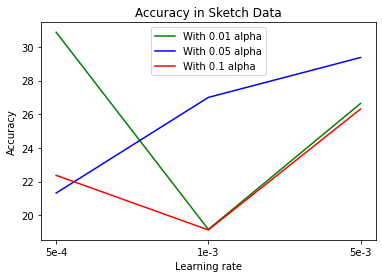

In [ ]:

acc_1 = [30.87, 19.16, 26.64]
acc_5 = [21.32, 27.00, 29.37 ]
acc_10 = [22.37, 19.13, 26.31]
test_lr = ["5e-4", "1e-3", "5e-3"]


plt.plot(test_lr, acc_1, 'g', label='With 0.01 alpha')
plt.plot(test_lr, acc_5, 'b', label='With 0.05 alpha')
plt.plot(test_lr, acc_10, 'r', label='With 0.1 alpha')
plt.title('Accuracy in Sketch Data')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      #transforms.RandomCrop( 64 , padding =2) ,
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])  
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                   
])

**Prepare Dataset**

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS.git
  

DATA_DIR_TRAIN = 'Homework3-PACS/PACS/photo'
DATA_DIR_TEST = 'Homework3-PACS/PACS/art_painting'
DATA_DIR_VAL = 'Homework3-PACS/PACS/cartoon'


# Prepare Pytorch train/test Datasets
train_dataset = torchvision.datasets.ImageFolder(DATA_DIR_TRAIN, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(DATA_DIR_TEST, transform=eval_transform)
val_dataset = torchvision.datasets.ImageFolder(DATA_DIR_VAL, transform=eval_transform)

'''
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
test_indexes = [idx for idx in range(len(test_dataset)) if not idx % 5]

train_dataset = Subset(train_dataset, train_indexes)
test_dataset = Subset(test_dataset, test_indexes)
'''

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))
print('Validation Dataset: {}'.format(len(val_dataset)))

Train Dataset: 1670
Test Dataset: 2048
Validation Dataset: 2344


In [ ]:

  

from torch.autograd import Function



class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

        

class AlexModel(nn.Module):
   

    def __init__(self):
        super(AlexModel, self).__init__()
        #self.restored = False
        model_alexnet = alexnet(pretrained=True)
        mod_alexnet = alexnet(pretrained=True)


        self.features = model_alexnet.features

         
      
        self.classifier=model_alexnet.classifier
        self.discriminator=mod_alexnet.classifier
       
        
    def forward(self, input_data, alpha=None):
        input_data = input_data.expand(input_data.data.shape[0], 3, 224, 224)
        features = self.features(input_data)
        #features = features.view(features.size(0), -1)

        features = features.view(-1, 256*6*6)
        if alpha is not None:
            # gradient reversal layer (backward gradients will be reversed)
            reverse_feature = ReverseLayerF.apply(features, alpha)
            discriminator_output = self.discriminator(reverse_feature)
            return discriminator_output
        # If we don't pass alpha, we assume we are training with supervision
        else:
            # do something else
            class_outputs = self.classifier(features)
            return class_outputs



In [ ]:
net = AlexModel() # Loading AlexNet model
net2= alexnet(pretrained=True)

net.classifier[6]=nn.Linear(4096, NUM_CLASSES)
net.discriminator[6]=nn.Linear(4096, 2)
print(net.classifier[6])
print(net.discriminator[6])


Linear(in_features=4096, out_features=7, bias=True)
Linear(in_features=4096, out_features=2, bias=True)


**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [ ]:

#net2.classifier[6] = nn.Linear(4096, NUM_CLASSES)


#print(net2.parameters)
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
#net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() 


  # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

#optimizer = optim.Adam(parameters_to_optimize, LR)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [ ]:
#lr=0.0001
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
min_loss=0.
min_epoch=0
cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
  len_dataloader = min(len(train_dataloader), len(test_dataloader))
  # Iterate over the dataset
  data_zip = enumerate(zip(train_dataloader, test_dataloader))
  #for images, labels in train_dataloader:
  for step, ((images_source, labels_source), (images_target, _)) in data_zip:
  #for images_source, labels_source in train_dataloader:  

    size_source = len(images_source)
    size_target = len(images_target)

    # Bring data over the device of choice
    images_source = images_source.to(DEVICE)
    labels_source = labels_source.to(DEVICE)
    images_target = images_target.to(DEVICE)

    net.train() # Sets module in training mode

   # p = float(step + epoch * len_dataloader) / NUM_EPOCHS / len_dataloader
   # alpha = 2. / (1. + np.exp(-10 * p)) - 1
   # lr = 0.01 / (1. + 10 * p)**0.75
    #for param_group in optimizer.param_groups:
        #param_group['lr'] = lr

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    output_source = net(images_source)
    disc_source = torch.zeros(size_source).long().to(DEVICE)  # source 0
    disc_target = torch.ones(size_target).long().to(DEVICE)  # target 1
    # Compute loss based on output and ground truth
    loss_source = criterion(output_source, labels_source)
    loss_source.backward()

    output_source_d = net(images_source, alpha)
    loss_source_d = criterion(output_source_d, disc_source)
    loss_source_d.backward()

    output_target_d = net(images_target, alpha)
    loss_target_d = criterion(output_target_d, disc_target)
    loss_target_d.backward()

    total_loss= loss_source+loss_source_d+loss_target_d
   
    if min_loss==0 or total_loss<min_loss:
      min_loss=total_loss
      min_epoch=epoch
    

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss source {} \n'.format(current_step, loss_source.item()))
      print('Step {}, Loss source discriminator {} \n'.format(current_step, loss_source_d.item()))
      print('Step {}, Loss target discriminator {} \n'.format(current_step, loss_target_d.item()))
      
    # Compute gradients for each layer and update weights
      # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
    #print('Alpha factor {} p factor {} '.format(alpha, p))

  # Step the scheduler
  print('Min_loss {}, min_epoch {} \n'.format(min_loss, min_epoch))
  scheduler.step() 

Starting epoch 1/25, LR = [0.005]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss source 1.995077133178711 

Step 0, Loss source discriminator 0.6738304495811462 

Step 0, Loss target discriminator 0.8489561676979065 

Step 10, Loss source 0.29830455780029297 

Step 10, Loss source discriminator 0.10490924119949341 

Step 10, Loss target discriminator 1.0352799892425537 

Step 20, Loss source 0.6693989038467407 

Step 20, Loss source discriminator 1.4416449069976807 

Step 20, Loss target discriminator 1.420478343963623 

Min_loss 0.534128725528717, min_epoch 0 

Starting epoch 2/25, LR = [0.005]
Step 30, Loss source 0.31866034865379333 

Step 30, Loss source discriminator 0.2501995861530304 

Step 30, Loss target discriminator 0.5830632448196411 

Step 40, Loss source 0.35299986600875854 

Step 40, Loss source discriminator 0.2792470455169678 

Step 40, Loss target discriminator 0.35090765357017517 

Step 50, Loss source 0.1091742217540741 

Step 50, Loss source discriminator 0.2111159861087799 

Step 50, Loss target discriminator 0.5530605912208557 



**Test**

In [ ]:

net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 32/32 [00:07<00:00,  4.14it/s]

Test Accuracy: 0.50048828125
